<a href="https://colab.research.google.com/github/chemvatho/isthmian-script/blob/main/PDF_to_OCR_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PDF to OCR Pipeline - Google Colab
Convert scanned PDFs to searchable text or Word documents.

**Features:**
- Two-column layout detection
- Multiple OCR engines: Tesseract, EasyOCR, PaddleOCR
- Output to TXT, DOCX, or JSON

## 1. Install Dependencies

In [1]:
# Install required packages
!apt-get update -qq
!apt-get install -y poppler-utils tesseract-ocr tesseract-ocr-spa tesseract-ocr-deu -qq

!pip install -q pdf2image pytesseract python-docx Pillow numpy tqdm

# Optional: Install EasyOCR (GPU-accelerated, good accuracy)
!pip install -q easyocr

# Optional: Install PaddleOCR (best accuracy)
# !pip install -q paddlepaddle-gpu paddleocr

print("✓ Dependencies installed!")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package poppler-utils.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.12_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.12) ...
Selecting previously unselected package tesseract-ocr-deu.
Preparing to unpack .../tesseract-ocr-deu_1%3a4.00~git30-7274cfa-1.1_all.deb ...
Unpacking tesseract-ocr-deu (1:4.00~git30-7274cfa-1.1) ...
Selecting previously unselected package tesseract-ocr-spa.
Preparing to unpack .../tesseract-ocr-spa_1%3a4.00~git30-7274cfa-1.1_all.deb ...
Unpacking tesseract-ocr-spa (1:4.00~git30-7274cfa-1.1) ...
Setting up tesseract-ocr-deu (1:4.00~git30-7274cfa-1.1) ...
Setting up tesseract-ocr-spa (1:4.00~git30-7274cfa-1.1) ...
Setting up poppler-utils (22.02.0-2ubuntu0.

## 2. Upload Your PDF

In [2]:
from google.colab import files
import os

# Upload PDF file
print("Select your PDF file to upload:")
uploaded = files.upload()

# Get the filename
PDF_PATH = list(uploaded.keys())[0]
print(f"\n✓ Uploaded: {PDF_PATH}")

Select your PDF file to upload:


Saving nahuatldictionary-2-pages.pdf to nahuatldictionary-2-pages.pdf

✓ Uploaded: nahuatldictionary-2-pages.pdf


## 3. Configuration

In [3]:
# ============== CONFIGURATION ==============
# Modify these settings as needed

# OCR Engine: "tesseract", "easyocr", or "paddleocr"
OCR_ENGINE = "tesseract"

# Language codes (for tesseract: eng, spa, deu, fra, lat, etc.)
# Combine with +: "eng+spa"
LANGUAGE = "lat+eng+spa"

# Image resolution (300 recommended, 400 for small text)
DPI = 300

# Page range (None = all pages)
FIRST_PAGE = None  # e.g., 1
LAST_PAGE = None   # e.g., 50

# Layout options
DETECT_COLUMNS = True  # Set False for single-column documents

# Output formats
OUTPUT_TXT = True
OUTPUT_DOCX = True
OUTPUT_JSON = False

# ============================================

print(f"OCR Engine: {OCR_ENGINE}")
print(f"Language: {LANGUAGE}")
print(f"DPI: {DPI}")
print(f"Pages: {FIRST_PAGE or 'first'} to {LAST_PAGE or 'last'}")
print(f"Column Detection: {DETECT_COLUMNS}")

OCR Engine: tesseract
Language: lat+eng+spa
DPI: 300
Pages: first to last
Column Detection: True


## 4. OCR Pipeline Code

In [4]:
import numpy as np
from PIL import Image
from pdf2image import convert_from_path
import pytesseract
from dataclasses import dataclass
from typing import List, Tuple, Optional
import json
from pathlib import Path

@dataclass
class OCRResult:
    page_num: int
    text: str
    confidence: Optional[float] = None


class ColumnDetector:
    """Detect and segment columns in document images"""

    def __init__(self, min_column_gap: int = 30):
        self.min_column_gap = min_column_gap

    def detect_columns(self, image: Image.Image) -> List[Tuple[int, int, int, int]]:
        gray = image.convert('L')
        img_array = np.array(gray)
        binary = (img_array < 200).astype(np.uint8)
        vertical_projection = np.sum(binary, axis=0)

        kernel_size = 20
        kernel = np.ones(kernel_size) / kernel_size
        smoothed = np.convolve(vertical_projection, kernel, mode='same')

        width = image.width
        height = image.height
        gap_threshold = np.mean(smoothed) * 0.1

        is_gap = smoothed < gap_threshold
        gaps = []
        in_gap = False
        gap_start = 0

        for i, g in enumerate(is_gap):
            if g and not in_gap:
                in_gap = True
                gap_start = i
            elif not g and in_gap:
                in_gap = False
                gap_width = i - gap_start
                if gap_width > self.min_column_gap:
                    gap_center = gap_start + gap_width // 2
                    if 0.2 * width < gap_center < 0.8 * width:
                        gaps.append(gap_center)

        if gaps:
            columns = []
            prev_x = 0
            for gap_x in sorted(gaps)[:1]:
                columns.append((prev_x, 0, gap_x, height))
                prev_x = gap_x
            columns.append((prev_x, 0, width, height))
            return columns
        else:
            return [(0, 0, width, height)]

    def split_image(self, image: Image.Image,
                    columns: List[Tuple[int, int, int, int]]) -> List[Image.Image]:
        return [image.crop((x1, y1, x2, y2)) for x1, y1, x2, y2 in columns]


class TesseractOCR:
    def __init__(self, lang: str = 'eng+spa'):
        self.lang = lang
        self.config = '--psm 1 --oem 3'

    def recognize(self, image: Image.Image) -> str:
        return pytesseract.image_to_string(image, lang=self.lang, config=self.config).strip()


class EasyOCREngine:
    def __init__(self, langs: List[str] = ['en', 'es']):
        import easyocr
        self.reader = easyocr.Reader(langs, gpu=True)

    def recognize(self, image: Image.Image) -> str:
        img_array = np.array(image)
        results = self.reader.readtext(img_array)
        results.sort(key=lambda x: (x[0][0][1], x[0][0][0]))

        lines = []
        current_line = []
        prev_y = None

        for bbox, text, conf in results:
            y = bbox[0][1]
            if prev_y is None or abs(y - prev_y) < 20:
                current_line.append(text)
            else:
                if current_line:
                    lines.append(' '.join(current_line))
                current_line = [text]
            prev_y = y

        if current_line:
            lines.append(' '.join(current_line))

        return '\n'.join(lines)


class PaddleOCREngine:
    def __init__(self, lang: str = 'en'):
        from paddleocr import PaddleOCR
        self.ocr = PaddleOCR(use_angle_cls=True, lang=lang, use_gpu=True, show_log=False)

    def recognize(self, image: Image.Image) -> str:
        img_array = np.array(image)
        results = self.ocr.ocr(img_array, cls=True)

        if not results or not results[0]:
            return ""

        text_items = []
        for line in results[0]:
            bbox, (text, conf) = line
            y_center = (bbox[0][1] + bbox[2][1]) / 2
            x_center = (bbox[0][0] + bbox[2][0]) / 2
            text_items.append((y_center, x_center, text))

        text_items.sort(key=lambda x: (x[0], x[1]))

        lines = []
        current_line = []
        prev_y = None

        for y, x, text in text_items:
            if prev_y is None or abs(y - prev_y) < 15:
                current_line.append((x, text))
            else:
                if current_line:
                    current_line.sort(key=lambda t: t[0])
                    lines.append(' '.join(t[1] for t in current_line))
                current_line = [(x, text)]
            prev_y = y

        if current_line:
            current_line.sort(key=lambda t: t[0])
            lines.append(' '.join(t[1] for t in current_line))

        return '\n'.join(lines)


def get_ocr_engine(engine_name: str, lang: str):
    """Factory function to create OCR engine"""
    if engine_name == 'tesseract':
        return TesseractOCR(lang=lang)
    elif engine_name == 'easyocr':
        lang_map = {'eng': 'en', 'spa': 'es', 'deu': 'de', 'fra': 'fr'}
        langs = [lang_map.get(l, l) for l in lang.split('+')]
        return EasyOCREngine(langs=langs)
    elif engine_name == 'paddleocr':
        return PaddleOCREngine(lang=lang.split('+')[0][:2])
    else:
        raise ValueError(f"Unknown OCR engine: {engine_name}")


print("✓ OCR Pipeline loaded!")

✓ OCR Pipeline loaded!


## 5. Run OCR

In [5]:
from tqdm import tqdm

# Initialize
print(f"Initializing {OCR_ENGINE} OCR engine...")
ocr_engine = get_ocr_engine(OCR_ENGINE, LANGUAGE)
column_detector = ColumnDetector() if DETECT_COLUMNS else None

# Convert PDF to images
print(f"\nConverting PDF to images at {DPI} DPI...")
images = convert_from_path(
    PDF_PATH,
    dpi=DPI,
    first_page=FIRST_PAGE,
    last_page=LAST_PAGE,
    fmt='png'
)
print(f"✓ Converted {len(images)} pages")

# Run OCR
print(f"\nRunning OCR...")
results = []
start_page = FIRST_PAGE or 1

for i, img in enumerate(tqdm(images, desc="OCR Progress")):
    page_num = start_page + i

    if DETECT_COLUMNS:
        columns = column_detector.detect_columns(img)
        segments = column_detector.split_image(img, columns)
        texts = [ocr_engine.recognize(seg) for seg in segments]
        full_text = '\n\n'.join(texts)
    else:
        full_text = ocr_engine.recognize(img)

    results.append(OCRResult(page_num=page_num, text=full_text))

print(f"\n✓ OCR complete! Processed {len(results)} pages.")

Initializing tesseract OCR engine...

Converting PDF to images at 300 DPI...
✓ Converted 10 pages

Running OCR...


OCR Progress: 100%|██████████| 10/10 [02:27<00:00, 14.73s/it]


✓ OCR complete! Processed 10 pages.


## 6. Preview Results

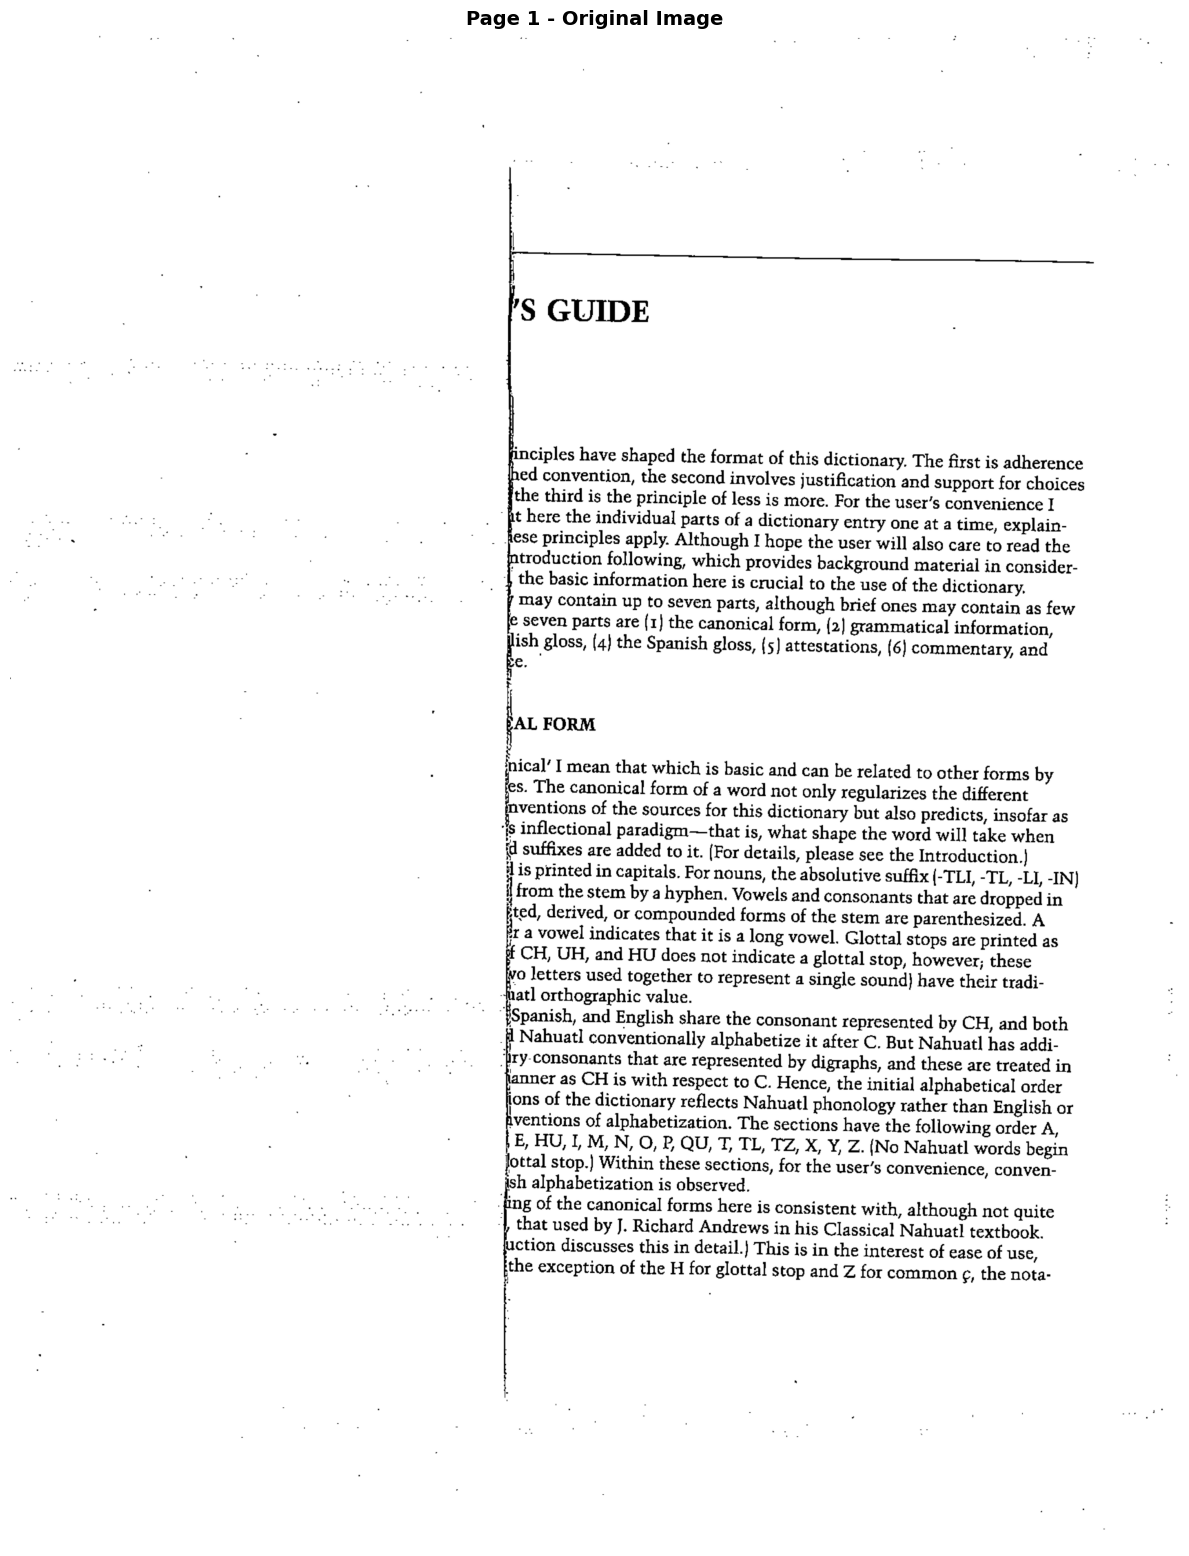


OCR TEXT - Page 1

o

inciples have shaped the format of this dictionary. The first is adherence
ed convention, the second involves justification and support for choices
the third is the principle of less is more. For the user’s convenience |

‘ft here the individual parts of a dictionary entry one at a time, explain-
#ese principles apply. Although I hope the user will also care to read the

troduction following, which provides background material in consider-

) the basic information here is crucial to the use of the dictionary,

may contain up to seven parts, although brief ones may contain as few
e seven parts are (1) the canonical form, (2) grammatical information,
gloss, (4) the Spanish gloss, (5) attestations, (6) commentary, and
Fe.

AL FORM

inical’ I mean that which is basic and can be related to other forms by
es. The canonical form of a word not only regularizes the different
mventions of the sources for this dictionary but also predicts, insofar as

‘s inflectional paradi

In [6]:
import matplotlib.pyplot as plt
from IPython.display import display, HTML

def preview_page_with_image(page_num, images, results, start_page=1, max_text_chars=3000):
    """
    Display page image and OCR text side by side

    Args:
        page_num: Page number to preview
        images: List of PIL images from pdf2image
        results: List of OCRResult objects
        start_page: First page number (default 1)
        max_text_chars: Maximum characters to display
    """
    # Find the result
    result = None
    for r in results:
        if r.page_num == page_num:
            result = r
            break

    if result is None:
        print(f"Page {page_num} not found. Available: {[r.page_num for r in results]}")
        return

    # Get corresponding image
    image_idx = page_num - start_page
    if image_idx < 0 or image_idx >= len(images):
        print(f"Image for page {page_num} not available")
        return

    img = images[image_idx]

    # Create figure with image
    fig, ax = plt.subplots(1, 1, figsize=(12, 16))
    ax.imshow(img)
    ax.set_title(f"Page {page_num} - Original Image", fontsize=14, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.show()

    # Display OCR text below
    print("\n" + "="*80)
    print(f"OCR TEXT - Page {page_num}")
    print("="*80 + "\n")

    text = result.text
    if len(text) > max_text_chars:
        print(text[:max_text_chars])
        print(f"\n... [{len(text) - max_text_chars} more characters]")
    else:
        print(text)

    print("\n" + "="*80)
    print(f"Total characters: {len(text)}")


# ============== PREVIEW A PAGE ==============
preview_page = 1  # Change this number to preview different pages

preview_page_with_image(
    page_num=preview_page,
    images=images,
    results=results,
    start_page=FIRST_PAGE or 1
)

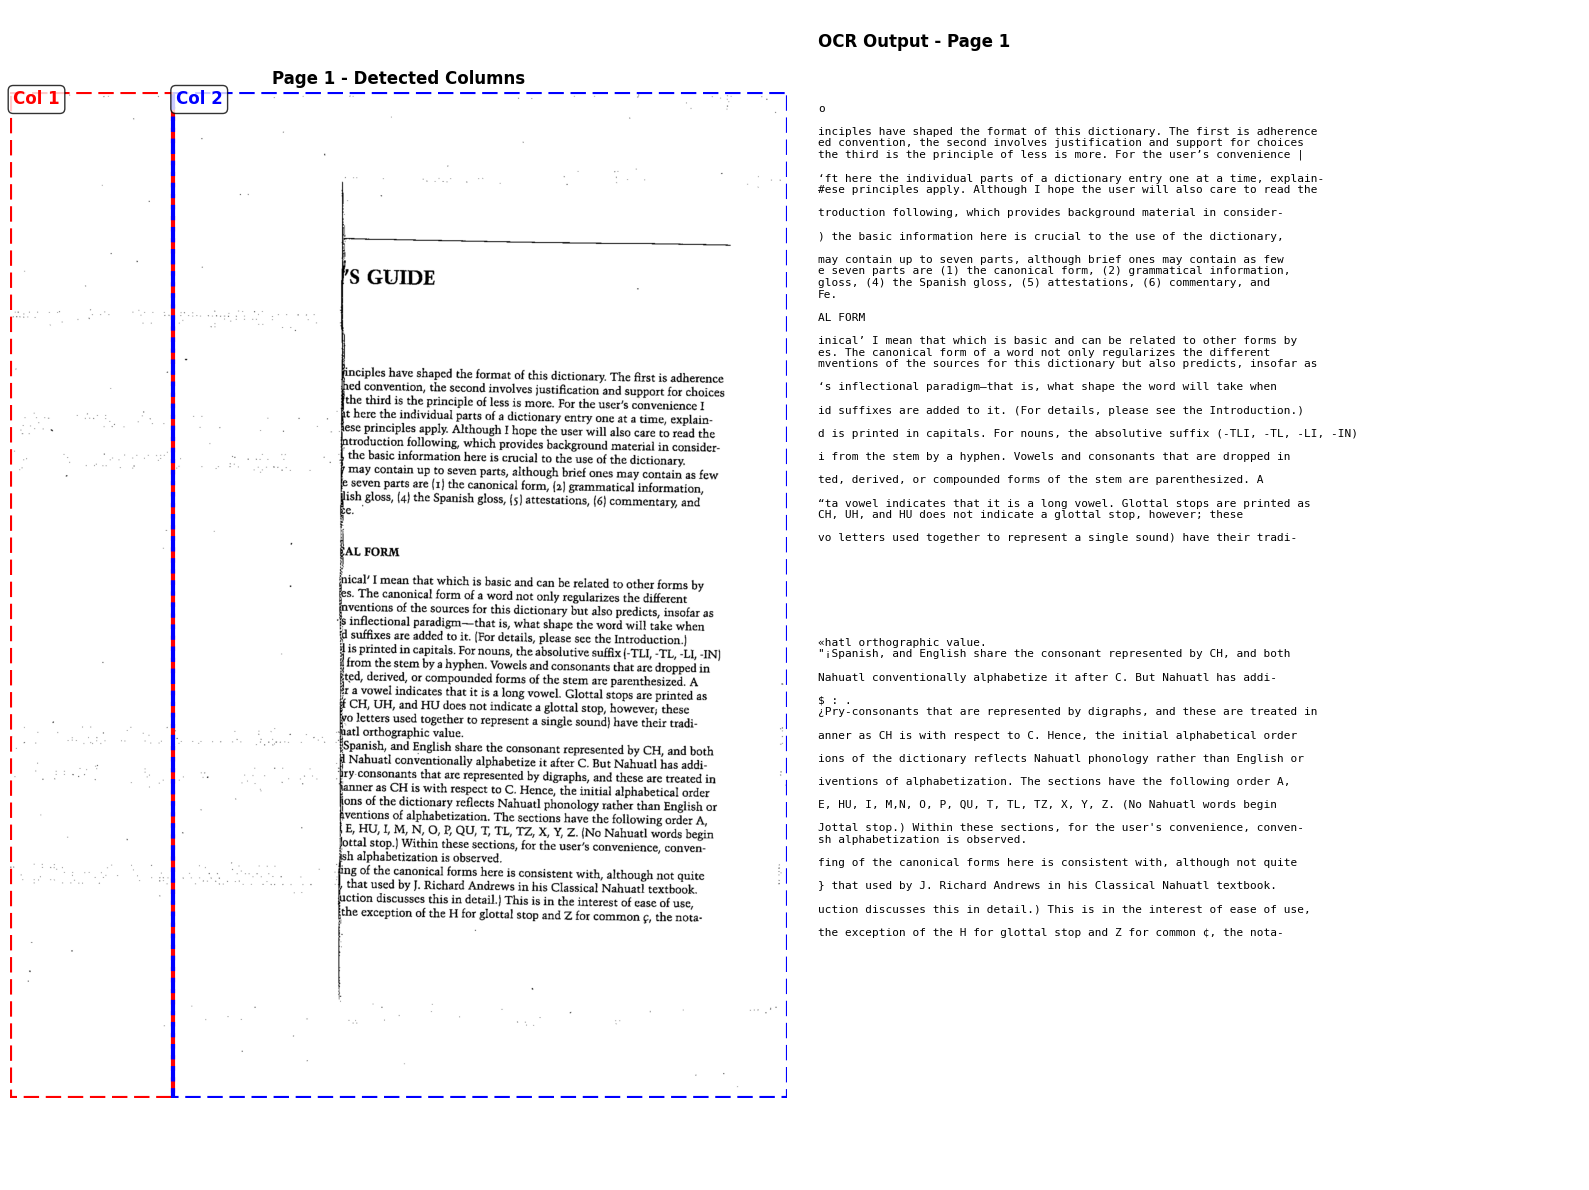


Detected 2 column(s)
Total OCR text: 2489 characters


In [7]:
# Alternative: Side-by-side view with columns highlighted

def preview_with_columns(page_num, images, results, start_page=1, detect_columns=True):
    """
    Display page with column detection overlay and OCR text
    """
    import matplotlib.patches as patches

    # Find result and image
    result = next((r for r in results if r.page_num == page_num), None)
    if result is None:
        print(f"Page {page_num} not found.")
        return

    image_idx = page_num - start_page
    if image_idx < 0 or image_idx >= len(images):
        print(f"Image not available.")
        return

    img = images[image_idx]

    # Detect columns
    if detect_columns:
        detector = ColumnDetector()
        columns = detector.detect_columns(img)
    else:
        columns = [(0, 0, img.width, img.height)]

    # Create figure
    fig, axes = plt.subplots(1, 2, figsize=(16, 12))

    # Left: Original image with column boxes
    axes[0].imshow(img)
    axes[0].set_title(f"Page {page_num} - Detected Columns", fontsize=12, fontweight='bold')

    colors = ['red', 'blue', 'green', 'orange']
    for i, (x1, y1, x2, y2) in enumerate(columns):
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            linewidth=3, edgecolor=colors[i % len(colors)],
            facecolor='none', linestyle='--'
        )
        axes[0].add_patch(rect)
        axes[0].text(x1+10, y1+40, f"Col {i+1}", fontsize=12,
                     color=colors[i % len(colors)], fontweight='bold',
                     bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    axes[0].axis('off')

    # Right: OCR text
    axes[1].text(0.02, 0.98, f"OCR Output - Page {page_num}",
                 transform=axes[1].transAxes, fontsize=12, fontweight='bold',
                 verticalalignment='top')

    # Truncate text for display
    display_text = result.text[:2500] if len(result.text) > 2500 else result.text
    if len(result.text) > 2500:
        display_text += f"\n\n[... {len(result.text) - 2500} more chars]"

    axes[1].text(0.02, 0.92, display_text,
                 transform=axes[1].transAxes, fontsize=8,
                 verticalalignment='top', fontfamily='monospace',
                 wrap=True)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"\nDetected {len(columns)} column(s)")
    print(f"Total OCR text: {len(result.text)} characters")


# ============== PREVIEW WITH COLUMNS ==============
preview_page = 1  # Change this number

preview_with_columns(
    page_num=preview_page,
    images=images,
    results=results,
    start_page=FIRST_PAGE or 1,
    detect_columns=DETECT_COLUMNS
)

## 7. Save & Download Results

In [ ]:
from google.colab import files as colab_files

base_name = Path(PDF_PATH).stem
output_files = []

# Save TXT
if OUTPUT_TXT:
    txt_path = f"{base_name}_ocr.txt"
    with open(txt_path, 'w', encoding='utf-8') as f:
        for r in results:
            f.write(f"--- Page {r.page_num} ---\n\n")
            f.write(r.text)
            f.write('\n\n')
    output_files.append(txt_path)
    print(f"✓ Saved: {txt_path}")

# Save DOCX
if OUTPUT_DOCX:
    from docx import Document
    from docx.shared import Pt
    from docx.enum.text import WD_ALIGN_PARAGRAPH

    doc = Document()
    style = doc.styles['Normal']
    style.font.name = 'Times New Roman'
    style.font.size = Pt(11)

    for r in results:
        header = doc.add_paragraph()
        header.alignment = WD_ALIGN_PARAGRAPH.CENTER
        run = header.add_run(f"— Page {r.page_num} —")
        run.bold = True

        for para_text in r.text.split('\n\n'):
            if para_text.strip():
                doc.add_paragraph(para_text.strip())

        if r.page_num < results[-1].page_num:
            doc.add_page_break()

    docx_path = f"{base_name}_ocr.docx"
    doc.save(docx_path)
    output_files.append(docx_path)
    print(f"✓ Saved: {docx_path}")

# Save JSON
if OUTPUT_JSON:
    json_path = f"{base_name}_ocr.json"
    data = [{'page': r.page_num, 'text': r.text} for r in results]
    with open(json_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)
    output_files.append(json_path)
    print(f"✓ Saved: {json_path}")

print(f"\n📥 Downloading {len(output_files)} file(s)...")
for f in output_files:
    colab_files.download(f)

## Alternative: Save to Google Drive

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Copy files to Drive
import shutil
drive_folder = '/content/drive/MyDrive/OCR_Output'
os.makedirs(drive_folder, exist_ok=True)

for f in output_files:
    dest = os.path.join(drive_folder, f)
    shutil.copy(f, dest)
    print(f"✓ Copied to: {dest}")

---
## Tips

**For best accuracy with your Nahuatl dictionary:**
- Use `tesseract` with `eng+spa` language
- DPI 300 is usually sufficient
- Column detection is ON by default (good for 2-column layout)

**If accuracy is poor:**
1. Try `easyocr` - better for some fonts
2. Increase DPI to 400
3. Try disabling column detection if layout is unusual

**For large PDFs (300+ pages):**
- Process in batches (e.g., pages 1-100, then 101-200)
- Use Colab Pro for longer runtime